# What is Julia

Julia is an open-source, high-performance, general purpose programming language, its main features are:

- JIT Just In Time compiler
- Dynamic type system
- Multiple dispatch
- Parametric polymorphism
- Supports macros

the web site for download and documentation is 
<br>
<br>

<center><font size="5">https://julialang.org/</font></center>


# The dual numbers treatment

A dual number is quantity of the type:

$$\textbf{x} \equiv x_0 + x_i\, \textbf{i}_i + x_{ij}\, \textbf{i}_{ij}$$

where :
-     $x_i$ are the components of the gradient 
-     $x_{ij}$ are the components of the Hessian. 

`D2` is the structure for storing the value, the gradient and the hessian of a quantity

In [1]:
struct D2{T,N,M} <:Number 
  v::T
  g::NTuple{N,T}
  h::NTuple{M,T}
end

where: 
* `v` is the of the parameter
* `g` is the gradient of `v`
* `h` is the Hessian. Since the Hessian is necessarily symmetric, we store and operate only on its upper triangular part, and we use a 1D data structure as follows


$$\left[\begin{matrix}
\mathbf{a_{11}} & \mathbf{a_{12}} & \mathbf{a_{13}} & \dots \\
a_{12} & \mathbf{a_{22}} & \mathbf{a_{23}} & \dots \\
a_{13} & a_{23} & \mathbf{a_{33}} & \dots \\
\vdots & \vdots & \vdots & \ddots
\end{matrix}\right] \qquad \Rightarrow \qquad \left[\begin{matrix}
\mathbf{a_{11}} & \mathbf{a_{12}} & \mathbf{a_{22}} & \mathbf{a_{13}} & \mathbf{a_{23}}  & \mathbf{a_{33}} & \dots \end{matrix}\right] $$ 

The type parameters are
- `T` the type of the values (can be Int, Float or Complex)
- `N` the number of independent variables controlling the gradient
- `M` = N(N+1)/2 is the number of independent elements in the Hessian


<hr>

#### extending opertors to work with `D2` type

we now need to properly extend the arithmetic opertors over the `D2` type, given two dual numbers of the type:
$$\mathbf{x} \equiv x_0 + x_i\, \mathbf{i}_i + x_{ij}\, \mathbf{i}_{ij}$$
$$\textbf{y} \equiv y_0 + y_i\, \textbf{i}_i + y_{ij}\, \textbf{i}_{ij}$$


- the sum is:
$$\textbf{x} + \textbf{y} = x_0+y_0 + \left(x_i+y_i\right) \textbf{i}_i + \left(x_{ij}+y_{ij}\right) \textbf{i}_{ij} $$


In [2]:
import Base: +, -, *, /, ^, inv, sqrt

@generated +(a::NTuple{N},b::NTuple{N}) where N = :(@inbounds $(Expr(:tuple, [:(a[$i]+b[$i]) for i in 1:N]...)))
@generated -(a::NTuple{N},b::NTuple{N}) where N = :(@inbounds $(Expr(:tuple, [:(a[$i]-b[$i]) for i in 1:N]...)))
@generated -(a::NTuple{N})              where N = :(@inbounds $(Expr(:tuple, [:(-a[$i]) for i in 1:N]...)))

+(x::D2, y::D2)      = D2(x.v+y.v, x.g + y.g, x.h + y.h)
-(x::D2, y::D2)      = D2(x.v-y.v, x.g - y.g, x.h - y.h)
-(x::D2)             = D2(-x.v,    -x.g,      -x.h)

- (generic function with 179 methods)

- the product is:

$$\textbf{x}  \textbf{y} = x_0y_0 + \left(y_0 x_i+x_0 y_i\right) \textbf{i}_i + \left(x_{ij}y_0 + x_i y_j + x_j y_i + x_0 y_{ij}\right) \textbf{i}_{ij} $$

$x_i y_j$ is the dyadic product of $x_i$ and $x_j$, and it is implemented as

$$\left[\begin{matrix}
\mathbf{x_{1}} & \mathbf{x_{2}} & \mathbf{x_{3}} & \dots \end{matrix}\right] \otimes \left[\begin{matrix}
\mathbf{y_{1}} & \mathbf{y_{2}} & \mathbf{y_{3}} & \dots \end{matrix}\right] = \left[\begin{matrix}
\mathbf{x_{1}y_{1}} & \mathbf{x_{1}y_{2}} & \mathbf{x_2 y_2} & \mathbf{x_1 y_3} & \mathbf{x_2 y_3} & \mathbf{x_3 y_3} & \dots \end{matrix}\right]$$


In [3]:
@generated *(a::T,b::NTuple{N}) where {N,T<:Number} = :(@inbounds $(Expr(:tuple, [:(a*b[$i]) for i in 1:N]...)))
*(a::NTuple{N},b::T) where {N,T<:Number}            = b*a
@generated ⊗(a::NTuple{N},b::NTuple{N}) where N     = :(@inbounds $(Expr(:tuple, [:(a[$i]b[$j]) for j in 1:N for i in 1:j]...)))

*(x::D2, y::D2)      = D2(x.v*y.v, x.g*y.v + y.g*x.v, x.h*y.v + x.v*y.h + x.g⊗y.g + y.g⊗x.g)
;

- the inverse is:
$$\frac{1}{\textbf{x}} = \frac{1}{x_0} - \frac{1}{x_0^2}\, x_i\, \textbf{i}_i + \left(\frac{2}{x_0^3} x_i x_j -\frac{1}{x_0} x_{ij}\right)\, \textbf{i}_{ij} $$


In [4]:
inv(x::D2)           = D2(1/x.v, 
                          (-1/x.v^2)*x.g, 
                          (2/x.v^3)*x.g⊗x.g + (-1/x.v^2)*x.h)
/(x::D2, y::D2)      = x*inv(y)
;

- the power is:

$$\textbf{x}^n = x_0^n + \left(n\,x_0^{n-1}\, x_i\right)\, \textbf{i}_i + \left[n\,(n-1)\,x_0^{n-2}\, x_ix_j + n\,x_0^{n-1}\, x_{ij}\right]\, \textbf{i}_{ij}$$

In [5]:
^(x::D2, n::Number)  = D2(x.v^n, (n*x.v^(n-1))*x.g,  (n*(n-1)*x.v^(n-2))*x.g⊗x.g + (n*x.v^(n-1))*x.h)
^(x::D2, n::Integer) = D2(x.v^n, (n*x.v^(n-1)).*x.g, (n*(n-1)*x.v^(n-2))*x.g⊗x.g + (n*x.v^(n-1))*x.h)
sqrt(x::D2)          = x^0.5
;

#### we also need to add conversion rules to work with scalars with a suitable constructor

when adding a dual number and a floating point number the folloing lines will make sure the the floating point number is translated in a dual number of the same type of the other operatorand with zeros gradient and zero hessian 

In [6]:
import Base:promote_rule
promote_rule(::Type{D2{T,N,M}}, ::Type{<:Number}) where {T,N,M} = D2{T,N,M}

D2{T,N,M}(x::Number) where {T,N,M} = D2(T(x), tuple(zeros(N)...), tuple(zeros(M)...))
;

#### an automated constructor for arrays is a handy tool



In [7]:
D2(x::T, g::NTuple{N}) where {T,N} = D2(T(x), T.(g), tuple(zeros(T,N*(N+1)÷2)...,))

D2(x::Array{T}) where T= begin
  N = length(x)
  [D2(x, tuple([T(i==j) for j in 1:N]...,)) for (i,x) in enumerate(x)]
end
;

#### data retrieving functions are also handy

In [8]:
val(x::D2)                       = x.v
grad(x::D2)                      = [x for x in x.g]
hess(x::D2{T,N,M}) where {T,N,M} = [x.h[get_index(i,j,N)] for i in 1:N, j in 1:N]

get_index(i,j,N)                 = i<j ? j*(j-1)÷2+i : i*(i-1)÷2+j
;

<hr>

#### One remark on macros: Julia's macros can build specialized functions on the fly

prepending `@generated` tells the compiler that what will follow is to be interpreted as a expression that is assembled and compiled at run time. In this way operations are not iterated but ar coded explicitly


let's check speed

In [9]:
using BenchmarkTools

a = randn(20)
b = randn(20)
@benchmark a + b

BenchmarkTools.Trial: 
  memory estimate:  240 bytes
  allocs estimate:  1
  --------------
  minimum time:     64.606 ns (0.00% GC)
  median time:      69.363 ns (0.00% GC)
  mean time:        87.091 ns (13.95% GC)
  maximum time:     44.523 μs (99.68% GC)
  --------------
  samples:          10000
  evals/sample:     979

In [10]:
a = tuple(a...)
b = tuple(b...)
@benchmark a + b

BenchmarkTools.Trial: 
  memory estimate:  176 bytes
  allocs estimate:  1
  --------------
  minimum time:     32.718 ns (0.00% GC)
  median time:      37.228 ns (0.00% GC)
  mean time:        53.755 ns (21.45% GC)
  maximum time:     45.977 μs (99.85% GC)
  --------------
  samples:          10000
  evals/sample:     993

<hr>

### Let's now test the `D2` type

first we define a generic function that takes three arguments and does some operations


In [11]:
f(x1,x2,x3) = x1^3*x2^2 + x3^2


f (generic function with 1 method)

we evaluate the function passing floating point numbers first

In [12]:
@show f(1, 1, 1)
;

f(1, 1, 1) = 2


the result is a floating point real number.

Now we evaluate the same function over `D2` arguments

In [13]:
x1 = D2(1, (1, 0, 0))
x2 = D2(1, (0, 1, 0))
x3 = D2(1, (0, 0, 1))

D2{Int64,3,6}(1, (0, 0, 1), (0, 0, 0, 0, 0, 0))

The position of the `1` in the gradient identify the independent variable.

We now call the same function with `x1`, `x2`, and `x3`. 

In [14]:
@show f(x1, x2, x3)
;

f(x1, x2, x3) = D2{Int64,3,6}(2, (3, 2, 2), (6, 6, 2, 0, 0, 2))


the result is a dual number

In [15]:
dump(f(x1,x2,x3))

D2{Int64,3,6}
  v: Int64 2
  g: Tuple{Int64,Int64,Int64}
    1: Int64 3
    2: Int64 2
    3: Int64 2
  h: NTuple{6,Int64}
    1: Int64 6
    2: Int64 6
    3: Int64 2
    4: Int64 0
    5: Int64 0
    6: Int64 2


In [16]:
grad(f(x1,x2,x3))

3-element Array{Int64,1}:
 3
 2
 2

In [17]:
hess(f(x1,x2,x3))

3×3 Array{Int64,2}:
 6  6  0
 6  2  0
 0  0  2

Since Julia is a JIT compiler and can handle multiple dispatch we do not need to make any change, while another version of function is compiled in the background the first time the function is called, and then executed.

We can us complex arguments

In [18]:
x1 = D2(1.0+5im, (1., 0., 0.).+0im, tuple(zeros(6).+0im...))
x2 = D2(1.0+2im, (0., 1., 0.).+0im, tuple(zeros(6).+0im...))
x3 = D2(1.0+2im, (0., 0., 1.).+0im, tuple(zeros(6).+0im...))

println("\n yd   :       ", f(x1, x2, x3),"\n")


 yd   :       D2{Complex{Float64},3,6}(659.0 + 38.0im, (96.0 - 378.0im, 292.0 - 516.0im, 2.0 + 4.0im), (-138.0 - 66.0im, -264.0 - 228.0im, -148.0 - 220.0im, 0.0 + 0.0im, 0.0 + 0.0im, 2.0 + 0.0im))



In [19]:
grad(f(x1,x2,x3))

3-element Array{Complex{Float64},1}:
  96.0 - 378.0im
 292.0 - 516.0im
   2.0 + 4.0im  

In [20]:
hess(f(x1,x2,x3))

3×3 Array{Complex{Float64},2}:
 -138.0-66.0im   -264.0-228.0im  0.0+0.0im
 -264.0-228.0im  -148.0-220.0im  0.0+0.0im
    0.0+0.0im       0.0+0.0im    2.0+0.0im

#### a polinominal function

In [21]:
f(x) = (x-1)*(x-2)*(x-3)*(x-4)

f (generic function with 2 methods)

In [22]:
x0   = collect(range(0.5, 4.5, length=200))

y_D2 = [f(D2(x, (1.0,))) for x in x0]
;

In [23]:
y_D2

200-element Array{D2{Float64,1,1},1}:
                                        D2{Float64,1,1}(6.5625, (-22.0,), (43.0,))
 D2{Float64,1,1}(6.1289107876104545, (-21.145342631949674,), (42.04002424181208,))
 D2{Float64,1,1}(5.712307341157008, (-20.309883804517902,), (41.089745208454325,))
   D2{Float64,1,1}(5.312305719210561, (-19.49342860866287,), (40.14916289992677,))
     D2{Float64,1,1}(4.9285258981117, (-18.695782135342757,), (39.2182773162294,))
 D2{Float64,1,1}(4.560591771970697, (-17.916749475515758,), (38.297088457362186,))
  D2{Float64,1,1}(4.208131152667506, (-17.156135720140053,), (37.38559632332516,))
  D2{Float64,1,1}(3.870775769851769, (-16.413745960173834,), (36.48380091411832,))
  D2{Float64,1,1}(3.548161270942812, (-15.689385286575298,), (35.59170222974168,))
   D2{Float64,1,1}(3.2399272211296424, (-14.98285879030262,), (34.7093002701952,))
  D2{Float64,1,1}(2.9457171033709546, (-14.293971562313983,), (33.8365950354789,))
 D2{Float64,1,1}(2.665178318395129, (-13.62252869

In [24]:
using PyPlot

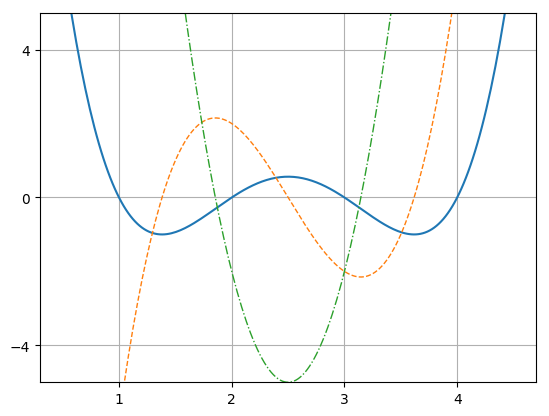

In [25]:
PyPlot.plot(x0, [y.v[1] for y in y_D2])
PyPlot.plot(x0, [y.g[1] for y in y_D2], linestyle=:dashed, linewidth=1)
PyPlot.plot(x0, [y.h[1] for y in y_D2], linestyle=:dashdot, linewidth=1)

PyPlot.ylim([-5, 5])
PyPlot.yticks([-4, 0, 4])
PyPlot.xticks([1, 2, 3, 4])
PyPlot.grid()

#### Arrays of numbers

In [26]:
x = D2([1, 2, 3])

3-element Array{D2{Int64,3,6},1}:
 D2{Int64,3,6}(1, (1, 0, 0), (0, 0, 0, 0, 0, 0))
 D2{Int64,3,6}(2, (0, 1, 0), (0, 0, 0, 0, 0, 0))
 D2{Int64,3,6}(3, (0, 0, 1), (0, 0, 0, 0, 0, 0))

In [27]:
 x[1]^3*x[2]^2 / x[3]^2

D2{Float64,3,6}(0.4444444444444444, (1.3333333333333333, 0.4444444444444444, -0.2962962962962963), (2.6666666666666665, 1.3333333333333333, 0.2222222222222222, -0.8888888888888888, -0.2962962962962963, 0.2962962962962963))

In [28]:
g(x) = x[1]^2-x[2]^2-4
;

In [29]:
x = range(-3, 3, length=50)
y = range(-3, 3, length=50)

xx = [x for y in y, x in x]
yy = [y for y in y, x in x]

@time zz = [g([x,y]) for x in x, y in y]
;

  0.148392 seconds (162.50 k allocations: 8.148 MiB)


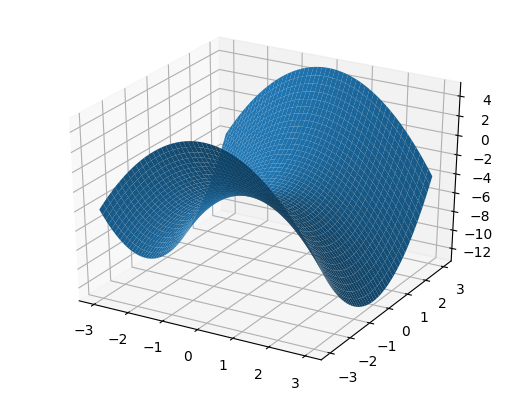

In [30]:
PyPlot.surf(xx,yy,zz)
;

In [31]:
@time zz_d = [g(D2([x,y])) for x in x, y in y]
;

  0.702170 seconds (1.02 M allocations: 51.697 MiB, 4.67% gc time)


In [32]:
zz_d[5,5]

D2{Float64,2,3}(-4.0, (-5.020408163265306, 5.020408163265306), (2.0, 0.0, -2.0))

In [33]:
grad(zz_d[5,5])

2-element Array{Float64,1}:
 -5.020408163265306
  5.020408163265306

In [34]:
hess(zz_d[5,5])

2×2 Array{Float64,2}:
 2.0   0.0
 0.0  -2.0

In [35]:
dzdx = [grad(z)[1] for z in zz_d]
dzdy = [grad(z)[2] for z in zz_d]

dzdxdx = [hess(z)[1,1] for z in zz_d]
dzdydy = [hess(z)[2,2] for z in zz_d]
dzdxdy = [hess(z)[1,2] for z in zz_d]
;

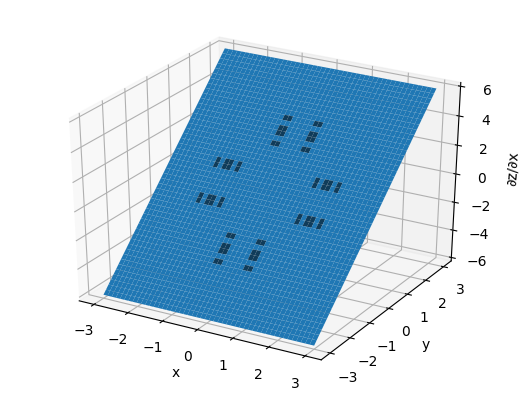

In [36]:
PyPlot.surf(x,y,dzdx)
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.zlabel("∂z/∂x")
;

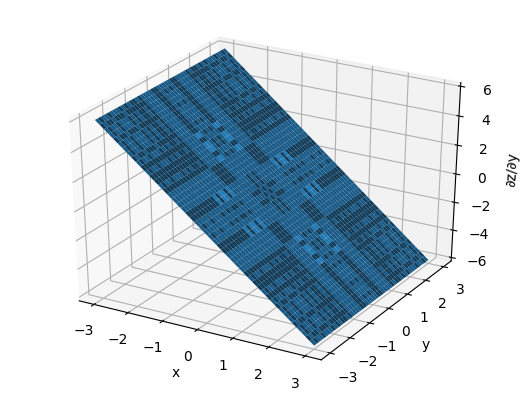

In [37]:
PyPlot.surf(x,y,dzdy)
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.zlabel("∂z/∂y")
;

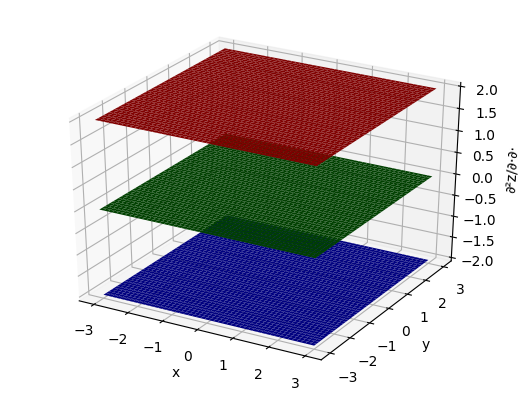

In [38]:
PyPlot.surf(x,y,dzdxdx, color=:red)
PyPlot.surf(x,y,dzdxdy, color=:green)
PyPlot.surf(x,y,dzdydy, color=:blue)

PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.zlabel("∂²z/∂⋅∂⋅")
;

# Application to solid mechanics - a truss structure

### The rod element

<img src="rod_element.svg" width="400"/>
#### the strain energy is 

$$\phi^\text{rod} = E_s \frac{ A l_0}{2} \left( \frac{l}{l_0}-1 \right)^2 \qquad \text{with} \qquad \begin{cases} l_0 &= \|\mathbf{r}_2-\mathbf{r}_1\| \\[10pt] l &= \|\mathbf{r}_2-\mathbf{r}_1 + \mathbf{u}_2-\mathbf{u}_1\| \end{cases}$$
<br><br>
#### the residual force vector and the tangent stiffness matrix are
<br><br>
$$
\begin{align*}
\mathbf{r} = \frac{\partial}{\partial \mathbf{u}}\phi^\text{rod} &= E_s A \left(\frac{l}{l_0}-1\right)\frac{\partial l}{\partial \mathbf{u}} \\[5pt]
\mathbf{K}_t = \frac{\partial^2}{\partial \mathbf{u}\partial \mathbf{u}}\phi^\text{rod} &= E_s A \left[\frac{1}{l_0} \frac{\partial l}{\partial \mathbf{u}} \frac{\partial l}{\partial \mathbf{u}} + \left(\frac{l}{l_0}-1\right)\frac{\partial^2 l}{\partial \mathbf{u}\partial \mathbf{u}}\right]
\end{align*}
$$
<br><br>
where
<br><br>
$$
\frac{\partial l}{\partial \mathbf{u}} = \frac{1}{l}\left[\begin{matrix}-\Delta r_1\\-\Delta r_2\\-\Delta r_3\\\Delta r_1\\\Delta r_2\\\Delta r_3\end{matrix}\right] 
\qquad \qquad
\frac{\partial^2 l}{\partial \mathbf{u}\partial \mathbf{u}} = \left[\begin{matrix}1&0&0&-1&0&0\\0&1&0&0&-1&0\\0&0&1&0&0&-1\\-1&0&0&1&0&0\\0&-1&0&0&1&0\\0&0&-1&0&0&1\end{matrix}\right]
$$

In [39]:
function calcFiKt(nodes, u)
  
  l0       = norm(nodes[:,2]-nodes[:,1])
  Δr       = nodes[:,2]+u[:,2] - (nodes[:,1]+u[:,1])
  l        = norm(Δr)  
  ϕ        = l0/2 *(l/l0-1)^2

  d2ldu2   =  diagm(0=>ones(6)) - diagm(3=>ones(3)) - diagm(-3=>ones(3))  
  Δx,Δy,Δz = Δr[:]
  dphidl   = (l/l0-1)/l0
  dphi2dl2 = 1/l0^2  
  dldu     = [-Δx, -Δy, -Δz, Δx, Δy, Δz]/l;
  fact1    = -dphidl/l^2 + dphi2dl2/l; 
  
  r        = dphidl * dldu;
  Kt       = fact1*l*(dldu*transpose(dldu)) + (dphidl/l)*d2ldu2

  (ϕ, r, Kt)
end

# this function iterate over all the elements
using SparseArrays
function calcFiKt(u, nodes, beams)
  
  N = length(u)
  ϕ, r, Kt = 0, zeros(N), spzeros(N,N)
  
  for beam in beams
    idxs          = LinearIndices(u)[:,beam[:]]    
    ϕFiKt         = calcFiKt(nodes[idxs], u[idxs])
    idxs          = idxs[:]
    ϕ             += ϕFiKt[1]
    r[idxs]       += ϕFiKt[2]
    Kt[idxs,idxs] += ϕFiKt[3]
  end
  (ϕ, r, Kt)  
end
;

This function evaluates the deformation energy for a single rod element

In [40]:
using LinearAlgebra

import LinearAlgebra: norm, dot

norm(x::Array{D2{T,N,M}} where {T,N,M}) = sqrt(sum(x.*x))

function getϕ(nodes, u)  
  l0       = norm(nodes[:,2]-nodes[:,1])
  Δr       = nodes[:,2]+u[:,2] - (nodes[:,1]+u[:,1])
  l        = norm(Δr)  
  ϕ        = l0/2 *(l/l0-1)^2
end

# this function iterate over all the elements
function getϕ(u, nodes, beams)
  
  N = length(u)
  ϕ, r, C = 0, zeros(N), spzeros(N,N)
  
  for beam in beams
    idxs         = LinearIndices(u)[:,beam[:]]    
    ϕEl          = getϕ(nodes[idxs], D2(u[idxs]))
    idxs         = idxs[:]
    ϕ            += val(ϕEl)
    r[idxs]      += grad(ϕEl)
    C[idxs,idxs] += hess(ϕEl)
  end  
  (ϕ, r, C) 
end

;

## the unit cell of the lattice
#### the regular Octet

In [41]:
L0    = sqrt(2)/2
nodes_RVE = [[0, 0, -sqrt(2)/2],
    [0, 0, sqrt(2)/2],
    [-1/2, -1/2, 0],
    [1/2, -1/2, 0],
    [1/2, 1/2, 0],
    [-1/2, 1/2, 0],
    [0, -1, sqrt(2)/2],
    [1, 0, sqrt(2)/2],
    [0, 1, sqrt(2)/2],
    [-1, 0, sqrt(2)/2],
    [0, -1, -sqrt(2)/2],
    [1, 0, -sqrt(2)/2],
    [0, 1, -sqrt(2)/2],
    [-1, 0, -sqrt(2)/2]] * L0
beams_RVE = [[9 5], [7 3], [8 4], [10 3], 
  [7 4], [9 6], [8 5], [10 6],
  [1 3], [1 4], [1 5], [1 6], [11 3],
  [13 5], [2 3], [2 4], [2 5], [2 6],
  [3 4], [4 5], [5 6], [6 3], [7 2], [8 2],
  [9 2], [10 2], [11 1],
  [12 1], [12 4], [12 5], [13 1], [13 6],
  [14 1], [14 3], [11 4], [14 6]]
R      = zeros(3,3)
R[1,:] = [sqrt(2)/2, sqrt(2)/2, 0]
R[2,:] = [sqrt(2)/2, -sqrt(2)/2, 0]
R[3,:] = [0, 0, 1];
nodes_RVE  = [R*v for v in nodes_RVE]
;

a few helper functions for replicating the unit cell along the periodic directions

In [42]:
using Printf

function write_scad_file(sFileName, nodes, beams; radius=0.05)
#= 
  write_scad_file is a helper function that produce a text file 
  with the coordinates, the nodes and the conectivity suitable 
  for drawing the model with openscad.
  The script polyhedron_hedges.scad is needed to produce the drawings
=#  
  open(sFileName, "w") do file    
    @printf(file, "\$fn = 8;")
    @printf(file, "radius = %.f;", radius)
    @printf(file, "use <polyhedron_hedges.scad>;")
    @printf(file, "nodes = [ \n")
    for node in nodes[1:end-1]
      @printf(file, "[%.f, %.f, %.f],\n", node...)
    end
    @printf(file, "[%.f, %.f, %.f]];\n", nodes[end]...)
    @printf(file, "edges = [\n")
    for beam in beams
      @printf(file, "[%i, %i],\n", beam...)
    end
    @printf(file, "[%i, %i]];", beams[end]...)
    @printf(file, "polyhedron_hedges(nodes, edges, radius);")
  end
end
;

using ProgressMeter

function replicateRVE(nodes_RVE, beams_RVE, 
    a1, a2, a3, N1, N2, N3)

  newnodes = [node + a1*i1+a2*i2+a3*i3 
    for i1 in 0:N1-1 
      for i2 in 0:N2-1 
        for i3 in 0:N3-1 
          for node in nodes_RVE]
  
  newbeams = [beam .+ (i3 + i2*N3 + i1*N3*N2)*14
    for i1 in 0:N1-1 
      for i2 in 0:N2-1
        for i3 in 0:N3-1
          for beam in beams_RVE]

  remove_duplicates!(newnodes, newbeams)
                                            
    (newnodes, newbeams)
end  

function remove_duplicates!(nodes, beams, dTol = 1e-3)

  
  id_rmnodes = []
  nnodes     = length(nodes)
  
  @showprogress 1 "removing duplicated nodes " for id1 in 1:nnodes-1
    for id2 in id1+1:nnodes
      dd = sum(abs.(nodes[id1]-nodes[id2]))
      if dd ≤ dTol
        for beam in beams
          beam[beam.==id2] .= id1
        end
        push!(id_rmnodes, id2)
      end
    end
  end
  
  sort!(unique!(id_rmnodes), rev=true)
  
  for item in id_rmnodes
    for beam in beams
      beam[beam.>item] .-=1
    end
  end

  deleteat!(nodes, sort!(id_rmnodes))
  
  println("found ", length(id_rmnodes), " duplicate nodes")
end


remove_duplicates! (generic function with 2 methods)

these functions evaluate the residual force vector and the tangent stiffness matrix with "traditional" FE

This function finds the solution with Newton Rhapson

In [43]:
function findu!(u, nodes, beams, idxf;
    bverb   = true, 
    dTol    = 1e-6,
    maxiter = 30, 
    bdual   = true)
  
  nDoFs   = length(idxf)
  updt    = zeros(nDoFs)
  iter    = 0
  bdone   = false
  bfailed = false
  
  if bverb
    p = ProgressThresh(dTol, "resudual norm:")
  end
  
  while !bdone && !bfailed
    global ϕ, r, C
    
    if bdual
      (ϕ, r, C)   = getϕ(u, nodes, beams)
    else
      (ϕ, r, C)   = calcFiKt(u, nodes, beams)
    end
      
    res         = r[idxf]
    normr       = norm(res)/nDoFs
    bverb && update!(p, normr)
      
    if normr ≤ dTol
       bdone = true
    elseif iter ≤ maxiter
        u[idxf] -= qr(C[idxf,idxf])\res
        iter += 1
    else
      println("failed to converge!")
      bfailed = true
    end
          
  end
  return ((ϕ, r, C), !bfailed)
end

findu! (generic function with 1 method)

In [44]:
a1 = [1, 0, 0]
a2 = [0, 1, 0]
a3 = [0, 0, 1]

N1 = 2
N2 = 2
N3 = 16
;

(nodes0, beams) = replicateRVE(nodes_RVE, beams_RVE, a1, a2, a3, N1, N2, N3)

println("the model includes ", length(beams), " beams and ", 
    length(nodes0), " nodes, ", 3*length(nodes0), " DoFs in total")

nodes = hcat(nodes0...)
;

removing duplicated nodes 100%|█████████████████████████| Time: 0:00:04


found 483 duplicate nodes
the model includes 2304 beams and 413 nodes, 1239 DoFs in total


#### write the openscad file with the underformed lattice

In [45]:
write_scad_file("octet_truss_undef.scad", nodes0, beams, radius=0.07)

### boundary conditions and solution

In [47]:
zmin, zmax = extrema(nodes[3,:])
xmin, xmax = extrema(nodes[1,:])
ymin, ymax = extrema(nodes[1,:])

xcg = (xmax+xmin)/2
ycg = (ymax+ymin)/2

nodes[1,:] .-= xcg
nodes[2,:] .-= ycg

id_top = findall(abs.(nodes[3,:].-zmax).<1e-5 )
id_btm = findall(abs.(nodes[3,:].-zmin).<1e-5 )
;

#### mark the constrained nodes

In [48]:
ifree = trues(size(nodes))
ifree[:,id_btm] .= false
ifree[1,id_top] .= false
ifree[2,id_top] .= false
idxf = findall(ifree[:])
;

#### the nodes on the top end are rotated by $\theta=\frac{\pi}{2}$

In [49]:
θ     = π/2
R     = [cos(θ) sin(θ) 0; -sin(θ) cos(θ) 0; 0 0 1]

u_top = hcat([R*nodes[:, id]-nodes[:,id] for id in id_top]...);

#### First solve using the "traditional" FE

In [50]:
u = zeros(size(nodes));
@time for LF in range(1/5, 1, length=5)
    u[1,id_top] .= LF*u_top[1,:]
    u[2,id_top] .= LF*u_top[2,:]
    if !findu!(u, nodes, beams, idxf, bdual=false)[2]
        break
    end
end
;

resudual norm: Time: 0:00:03 (5 iterations)-05)
resudual norm: Time: 0:00:02 (6 iterations)-06)
resudual norm: Time: 0:00:01 (5 iterations)-05)
resudual norm: Time: 0:00:02 (5 iterations)-06)
resudual norm: Time: 0:00:02 (5 iterations)-06)


 14.343525 seconds (12.73 M allocations: 19.148 GiB, 15.28% gc time)


#### now solve with dual number

In [51]:
u_d          = zeros(size(nodes));
@time for LF in range(1/5, 1, length=5)
    u_d[1,id_top] .= LF*u_top[1,:]
    u_d[2,id_top] .= LF*u_top[2,:]
    if !findu!(u_d, nodes, beams, idxf, bdual=true)[2]
        break
    end
end
;

resudual norm: Time: 0:00:03 (5 iterations)-05)
resudual norm: Time: 0:00:02 (6 iterations)-06)
resudual norm: Time: 0:00:02 (5 iterations)-05)
resudual norm: Time: 0:00:02 (5 iterations)-06)
resudual norm: Time: 0:00:02 (5 iterations)-06)


 13.973833 seconds (38.36 M allocations: 20.412 GiB, 16.27% gc time)


#### the sdifference between the two solutions is 

In [52]:
maximum(abs.(u-u_d))

2.220446049250313e-15

#### write the openscad file with the derformed lattice

In [53]:
write_scad_file("octet_truss_def.scad", [nodes[:,ii]+u_d[:,ii] for ii in 1:size(nodes)[2]], 
    beams, radius=0.07)    


#### a benchmark

we now check the speed of the classic FE implementation and the dual number implementation, we also check the speed of the more complete implementation of dual numbers of AD4SM.jl

In [54]:
u_benchmark            = randn(size(nodes));

In [55]:
using AD4SM

# this function iterate over all the elements
function getϕD2(u, nodes, beams)
  
  N = length(u)
  ϕ, r, C = 0, zeros(N), spzeros(N,N)
  
  for beam in beams
    idxs         = LinearIndices(u)[:,beam[:]]    
    ϕEl          = getϕ(nodes[idxs], adiff.D2(u[idxs]))
    idxs         = idxs[:]
    ϕ            += adiff.val(ϕEl)
    r[idxs]      += adiff.grad(ϕEl)
    C[idxs,idxs] += adiff.hess(ϕEl)
  end  
  (ϕ, r, C) 
end

;

In [61]:
@benchmark (ϕ1, r1, K1) = calcFiKt(u_benchmark, nodes, beams)

BenchmarkTools.Trial: 
  memory estimate:  748.31 MiB
  allocs estimate:  179024
  --------------
  minimum time:     321.509 ms (20.40% GC)
  median time:      325.303 ms (20.20% GC)
  mean time:        331.873 ms (21.71% GC)
  maximum time:     426.753 ms (38.54% GC)
  --------------
  samples:          16
  evals/sample:     1

In [59]:
@benchmark (ϕ2, r2, K2) = getϕ(u_benchmark, nodes, beams)

BenchmarkTools.Trial: 
  memory estimate:  808.96 MiB
  allocs estimate:  1388623
  --------------
  minimum time:     414.379 ms (18.59% GC)
  median time:      419.010 ms (18.58% GC)
  mean time:        427.628 ms (20.10% GC)
  maximum time:     523.302 ms (33.54% GC)
  --------------
  samples:          12
  evals/sample:     1

In [60]:
@benchmark (ϕ2, r2, K2) = getϕD2(u_benchmark, nodes, beams)

BenchmarkTools.Trial: 
  memory estimate:  760.48 MiB
  allocs estimate:  146768
  --------------
  minimum time:     325.691 ms (19.61% GC)
  median time:      330.729 ms (20.01% GC)
  mean time:        337.219 ms (21.41% GC)
  maximum time:     429.525 ms (37.48% GC)
  --------------
  samples:          15
  evals/sample:     1